In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras 
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.layers import Conv2D,MaxPool2D,BatchNormalization,Dropout,Flatten
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import  ModelCheckpoint
import keras
from sklearn.metrics import classification_report,confusion_matrix
import os
from tensorflow.python.client import device_lib
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.models import model_from_json

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("tensorflow version: "+tf.__version__)
print("numpy version: "+np.__version__)
print("keras version: "+keras.__version__)

tensorflow version: 2.4.0
numpy version: 1.19.3
keras version: 2.4.3


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5713310867251236257
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3030515712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7548039380751124634
physical_device_desc: "device: 0, name: GeForce GTX 1650 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


In [5]:
test_path = r'D:\Akhilesh\Data\Pneumonia\chest_xray\test'
train_path = r'D:\Akhilesh\Data\Pneumonia\chest_xray\train'
val_path = r'D:\Akhilesh\Data\Pneumonia\chest_xray\val'
train_datagen = ImageDataGenerator( rotation_range=30,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rescale=1./255)
test_val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,target_size=(128,128),class_mode='binary',batch_size=32)
test_set = test_val_datagen.flow_from_directory(test_path,target_size=(128,128),class_mode='binary',batch_size=32)
val_set = test_val_datagen.flow_from_directory(val_path,target_size=(128,128),class_mode='binary',batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


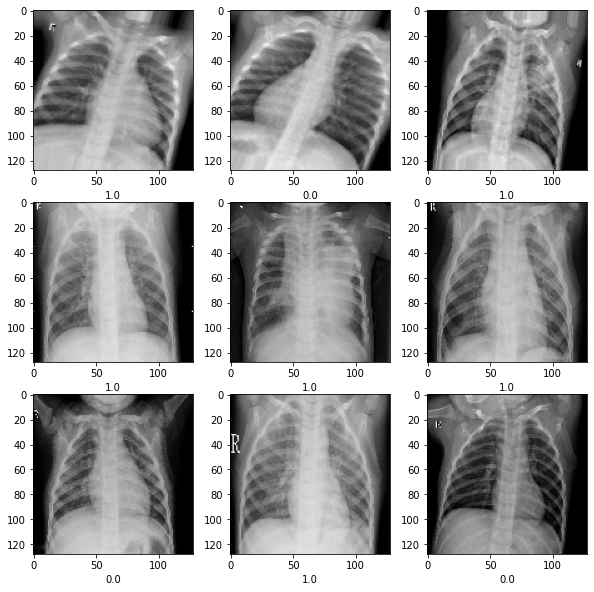

In [6]:
training_photos = training_set[0]
test_photos = test_set[0]
val_photos = val_set[0]
plt.subplots(3,3,figsize=(10,10))
for i in range(1,4):
    plt.subplot(3,3,i)
    plt.imshow(training_photos[0][i])
    plt.xlabel(training_photos[1][i])
for i in range(4,7):
    plt.subplot(3,3,i)
    plt.imshow(test_photos[0][i])
    plt.xlabel(test_photos[1][i])
for i in range(7,10):
    plt.subplot(3,3,i)
    plt.imshow(val_photos[0][i])
    plt.xlabel(val_photos[1][i])

In [7]:
COUNT_PNEUMONIA = 1342
COUNT_NORMAL = 3876
TOTAL = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TOTAL) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TOTAL) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 0.67
Weight for class 1: 1.94


In [8]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
checkpoint = ModelCheckpoint(r'C:\Users\Akhilesh\Desktop\Programs\Projects\Pneumonia\Best weight\weight.h5', verbose=1, save_best_only=True)
initial_learning_rate = 0.01
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
#early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [9]:
model = Sequential()
model.add(Conv2D(16,(3,3),padding='Same',activation='relu',input_shape = (128,128,3)))
model.add(Conv2D(16,(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(32,(3,3),activation='relu',padding='Same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu',padding='Same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3),activation='relu',padding='Same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='Same'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1 , activation = 'sigmoid'))
adam = Adam(learning_rate=lr_schedule,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer = adam,loss = 'binary_crossentropy' , metrics = METRICS) 

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9

In [13]:
STEPS_PER_EPOCH = 5
EPOCHS = 200

In [14]:
history = model.fit(training_set, 
                    validation_data = val_set ,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    callbacks=[checkpoint] ,
                    class_weight=class_weight,
                    epochs=EPOCHS)

Epoch 1/200
5/5 [==============================] - 7s 656ms/step - loss: 1.5831 - binary_accuracy: 0.4641 - precision: 0.7277 - recall: 0.4697 - val_loss: 45.1437 - val_binary_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 45.14370, saving model to C:\Users\Akhilesh\Desktop\Programs\Projects\Pneumonia\Best weight\weight.h5
Epoch 2/200
5/5 [==============================] - 2s 319ms/step - loss: 1.0870 - binary_accuracy: 0.6832 - precision: 0.8592 - recall: 0.7087 - val_loss: 102.6095 - val_binary_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_loss did not improve from 45.14370
Epoch 3/200
5/5 [==============================] - 2s 323ms/step - loss: 1.1300 - binary_accuracy: 0.6786 - precision: 0.8211 - recall: 0.7452 - val_loss: 19.5823 - val_binary_accuracy: 0.5625 - val_precision: 0.6667 - val_recall: 0.2500

Epoch 00003: val_loss improved from 45.14370 to 19.58228, saving mode


Epoch 00026: val_loss did not improve from 3.71873
Epoch 27/200
5/5 [==============================] - 2s 312ms/step - loss: 0.2486 - binary_accuracy: 0.8797 - precision: 0.8773 - recall: 0.9860 - val_loss: 4.7918 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00027: val_loss did not improve from 3.71873
Epoch 28/200
5/5 [==============================] - 2s 334ms/step - loss: 0.3737 - binary_accuracy: 0.7614 - precision: 0.7516 - recall: 0.9735 - val_loss: 6.2570 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00028: val_loss did not improve from 3.71873
Epoch 29/200
5/5 [==============================] - 2s 344ms/step - loss: 0.3304 - binary_accuracy: 0.8036 - precision: 0.7804 - recall: 0.9895 - val_loss: 8.9491 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00029: val_loss did not improve from 3.71873
Epoch 30/200
5/5 [==============================] - 2s 333ms/step - loss: 0.33

5/5 [==============================] - 2s 330ms/step - loss: 0.2765 - binary_accuracy: 0.8555 - precision: 0.8586 - recall: 0.9598 - val_loss: 1.3145 - val_binary_accuracy: 0.4375 - val_precision: 0.4667 - val_recall: 0.8750

Epoch 00081: val_loss did not improve from 0.69074
Epoch 82/200
5/5 [==============================] - 2s 336ms/step - loss: 0.1805 - binary_accuracy: 0.9296 - precision: 0.9206 - recall: 0.9883 - val_loss: 1.2319 - val_binary_accuracy: 0.5625 - val_precision: 0.5385 - val_recall: 0.8750

Epoch 00082: val_loss did not improve from 0.69074
Epoch 83/200
5/5 [==============================] - 2s 332ms/step - loss: 0.2249 - binary_accuracy: 0.9278 - precision: 0.9230 - recall: 0.9840 - val_loss: 1.0667 - val_binary_accuracy: 0.5625 - val_precision: 0.5385 - val_recall: 0.8750

Epoch 00083: val_loss did not improve from 0.69074
Epoch 84/200
5/5 [==============================] - 2s 334ms/step - loss: 0.2153 - binary_accuracy: 0.8989 - precision: 0.9199 - recall: 0.9636


Epoch 00136: val_loss did not improve from 0.62436
Epoch 137/200
5/5 [==============================] - 2s 361ms/step - loss: 0.2741 - binary_accuracy: 0.8780 - precision: 0.8625 - recall: 0.9842 - val_loss: 2.0056 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00137: val_loss did not improve from 0.62436
Epoch 138/200
5/5 [==============================] - 2s 383ms/step - loss: 0.2140 - binary_accuracy: 0.8981 - precision: 0.9004 - recall: 0.9695 - val_loss: 2.2690 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00138: val_loss did not improve from 0.62436
Epoch 139/200
5/5 [==============================] - 2s 357ms/step - loss: 0.1834 - binary_accuracy: 0.9256 - precision: 0.9113 - recall: 0.9927 - val_loss: 2.5386 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00139: val_loss did not improve from 0.62436
Epoch 140/200
5/5 [==============================] - 2s 337ms/step - loss: 

Epoch 165/200
5/5 [==============================] - 2s 339ms/step - loss: 0.1995 - binary_accuracy: 0.8738 - precision: 0.8644 - recall: 0.9899 - val_loss: 1.6328 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00165: val_loss did not improve from 0.62436
Epoch 166/200
5/5 [==============================] - 2s 351ms/step - loss: 0.1717 - binary_accuracy: 0.9003 - precision: 0.8855 - recall: 1.0000 - val_loss: 1.6674 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00166: val_loss did not improve from 0.62436
Epoch 167/200
5/5 [==============================] - 2s 363ms/step - loss: 0.3039 - binary_accuracy: 0.8832 - precision: 0.8893 - recall: 0.9661 - val_loss: 1.5546 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 00167: val_loss did not improve from 0.62436
Epoch 168/200
5/5 [==============================] - 2s 342ms/step - loss: 0.2893 - binary_accuracy: 0.8735 - precision: 0.8727

In [97]:
matrix = model.evaluate(test_set,return_dict=True,verbose=0)
for i,j in matrix.items():
    print(str(i)+' is '+str(j))

loss is 0.3298150300979614
binary_accuracy is 0.8910256624221802
precision is 0.8797169923782349
recall is 0.9564102292060852


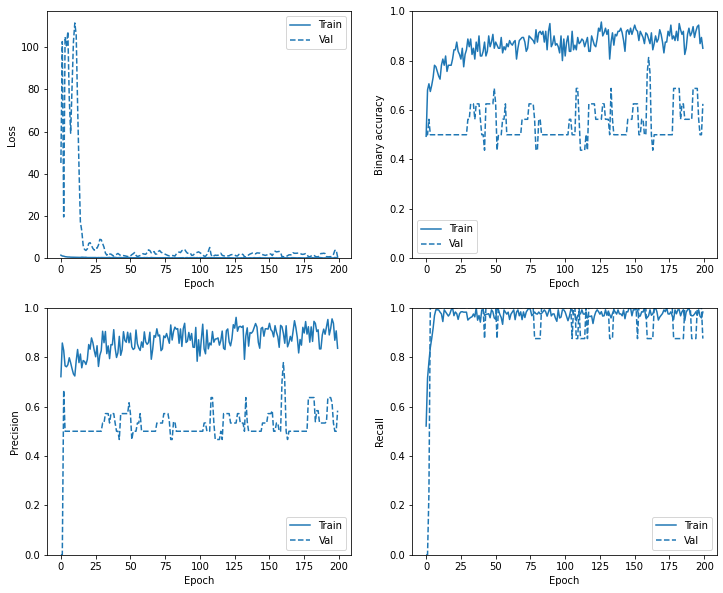

In [105]:
mpl.rcParams['figure.figsize'] = (12, 10)
metrics =  [matrix for matrix in matrix.keys()]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

model_json = model.to_json()
with open(r'C:\Users\Akhilesh\Desktop\Programs\Projects\Pneumonia\Best weight\model.json', "w") as json_file:
    json_file.write(model_json)
model.save(r'../Best weight/model/model.h5')

In [28]:
def reshape_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(128,128))
    image = image/255
    image = image.reshape(1,128,128,3)
    return image

In [101]:
path = r'D:\Akhilesh\Data\Pneumonia\chest_xray\chest_xray\train\NORMAL\IM-0117-0001.jpeg'
#plt.imshow(image)
model.predict(reshape_image(path))

array([[0.16561241]], dtype=float32)

In [102]:
path = r'D:\Akhilesh\Data\Pneumonia\chest_xray\chest_xray\train\PNEUMONIA\person1_bacteria_1.jpeg'
#plt.imshow(image)
model.predict(reshape_image(path))

array([[0.98327374]], dtype=float32)

In [103]:
path = r'D:\Akhilesh\Data\Pneumonia\chest_xray\chest_xray\test\NORMAL\IM-0001-0001.jpeg'
model.predict(reshape_image(path))

array([[0.05714935]], dtype=float32)

In [104]:
path = r'D:\Akhilesh\Data\Pneumonia\chest_xray\chest_xray\test\PNEUMONIA\person1_virus_6.jpeg'
model.predict(reshape_image(path))

array([[0.9678904]], dtype=float32)

In [4]:
json_file = open(r'../Best weight/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(r'../Best weight/weight.h5')
loaded1_model = load_model(r'../Best weight/model/model.h5',compile=False)

In [56]:
path = r'D:\Akhilesh\Data\Pneumonia\chest_xray\chest_xray\train\PNEUMONIA\person1_bacteria_2.jpeg'
loaded1_model.predict(reshape_image(path)),loaded_model.predict(reshape_image(path))

(array([[0.80478394]], dtype=float32), array([[0.80478394]], dtype=float32))

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded1_model)
tflite_model = converter.convert()
with open(r'../Best weight/model/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Akhilesh\AppData\Local\Temp\tmpmmfy5q4a\assets


In [1]:
from tflite_model_maker import ExportFormat

ModuleNotFoundError: No module named 'tflite_model_maker'